In [94]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix,classification_report
from evidently.report import Report
from evidently.metric_preset import ClassificationPreset
from evidently import ColumnMapping

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn import svm

import warnings; warnings.filterwarnings('ignore')

### Import the Animal Dataset containing segments of sheep as well as goat 

In [2]:
ds = pd.read_csv('Data/Animal.csv', sep=',')

In [3]:
ds.head(2)

,Unnamed: 0,label,animal_ID,segment_ID,timestamp_ms,ax,ay,az,axhg,ayhg,azhg,cx,cy,cz,gx,gy,gz,pressure,temp
0,0,walking,S1,1,1,-2.73178,-6.68701,-6.57208,2.13233,-5.37588,17.8696,1.5525,-0.4755,0.5415,2.012200,-51.3415,-32.6220,NaN,27.38
1,1,walking,S1,1,6,-2.78206,-6.82347,-6.62954,1.71187,-3.27358,17.3290,NaN,NaN,NaN,-0.121951,-47.3171,-33.5366,NaN,27.39


In [4]:
ds.shape

(12609524, 19)

In [5]:
ds.drop(columns=ds.columns[0], inplace=True)

In [6]:
ds['segment_ID'].nunique()

4114

There are 4114 segments present in the following dataset.

Analyzing a segment and it's label.

In [7]:
ds_seg = ds[ds.segment_ID==1]

Here there are 1572 data points in this segment. 

Let's check if the timestamp is continuous.

In [9]:
def checkTimeStampContinuous(TimeSeries):
    if (TimeSeries.diff().unique()[1] == 5.0):
        return True
    else:
        False
checkTimeStampContinuous(ds_seg['timestamp_ms'])

True

Let's find out the number of data points present in each segment.

[]

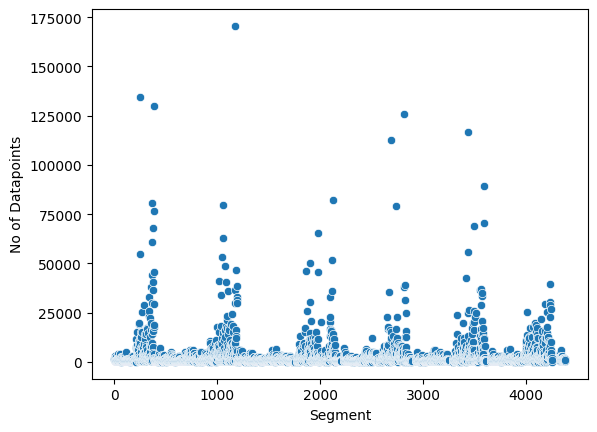

In [10]:
points_per_segment = []

for segment in ds['segment_ID'].unique():
    points_per_segment.append(ds[ds['segment_ID']==segment].shape[0])

sns.scatterplot(x=ds['segment_ID'].unique(),y = points_per_segment)
plt.xlabel('Segment')
plt.ylabel('No of Datapoints')
plt.plot()

Since each segment has uneven number of data points, we have to now check if the data points in each segment have the same label.


In [11]:
def labelCheck(segmentLabelSeries):
    if(len(segmentLabelSeries.unique())==1):
        return True
    else:
        False

for segment in ds['segment_ID'].unique():
    if(labelCheck(ds[ds['segment_ID']==segment]['label'])):
        pass
    else:
        print('Segment {} has a different label set.'.format(segment))

print("Check Completed!")


Check Completed!


Segment Visualization

Total Labels: 4114

Segments per label: 

walking     1499
standing    1404
trotting     549
grazing      336
running      326
Name: count, dtype: int64


Text(0, 0.5, 'Labels')

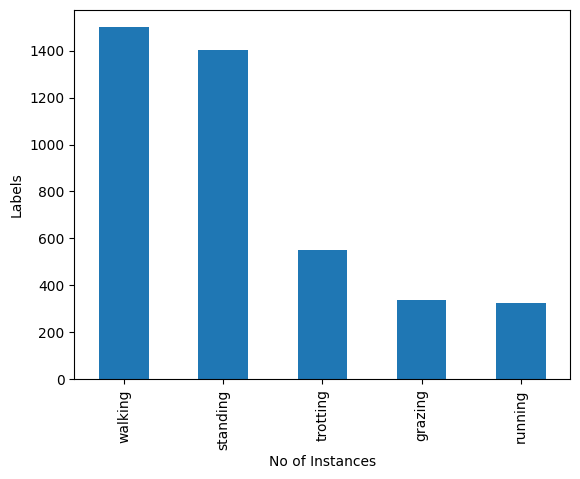

In [12]:
label_per_segment = []

for segment in ds['segment_ID'].unique():
    label_per_segment.append(ds[ds['segment_ID']==segment]['label'].unique()[0])


print("Total Labels: {}\n".format(len(label_per_segment)))
print("Segments per label: \n")
print(pd.Series(label_per_segment).value_counts())

pd.Series(label_per_segment).value_counts().plot(kind='bar')
plt.xlabel('No of Instances')
plt.ylabel('Labels')

[]

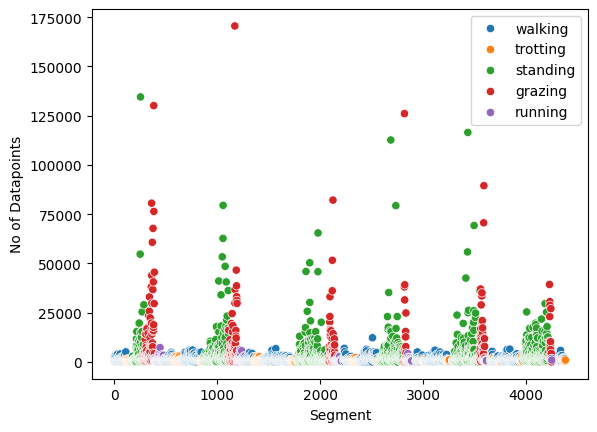

In [13]:
points_per_segment = []
label_per_segment = []

for segment in ds['segment_ID'].unique():
    points_per_segment.append(ds[ds['segment_ID']==segment].shape[0])
    label_per_segment.append(ds[ds['segment_ID']==segment]['label'].unique()[0])

sns.scatterplot(x=ds['segment_ID'].unique(),y = points_per_segment,hue=label_per_segment)
plt.xlabel('Segment')
plt.ylabel('No of Datapoints')
plt.plot()

We can see from the above plot, that the classes are imbalanced. These are the observations:
- Technically, the act of grazing and walking can be considered similar, since both sheep usually graze the field walking. (Will need to look into this as well.)


Let's analyse each segments signals to deduce the fluctuation among different classes.

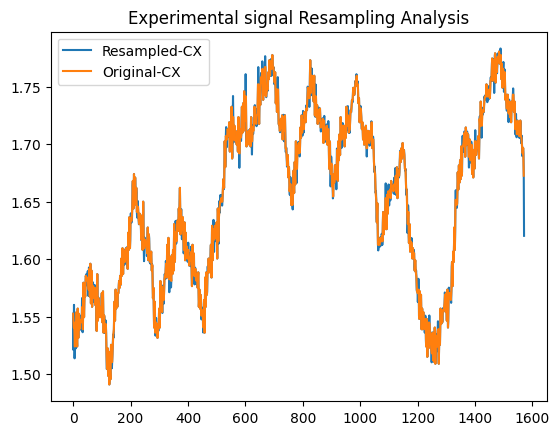

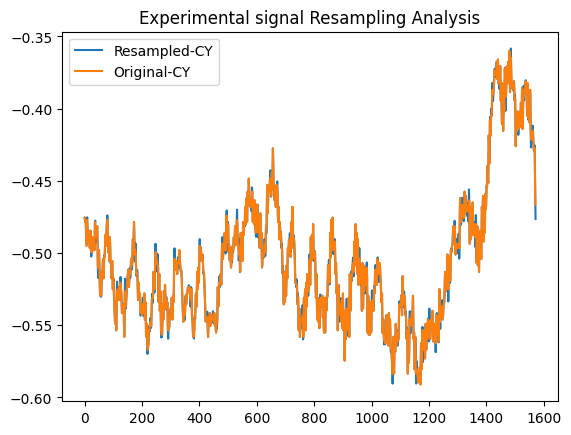

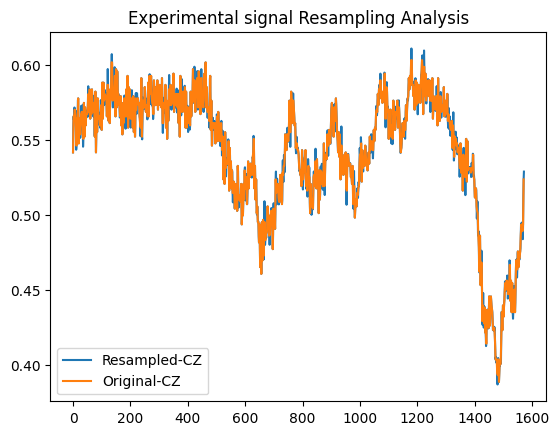

1.6533091603053431


In [14]:
# Experimental Signal Resampling
segment = 1
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CX')
ds[ds['segment_ID']==segment]['cx'].dropna().plot(label='Original-CX')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cy'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CY')
ds[ds['segment_ID']==segment]['cy'].dropna().plot(label='Original-CY')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()
pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cz'].dropna(),ds[ds['segment_ID']==segment].shape[0])).plot(label='Resampled-CZ')
ds[ds['segment_ID']==segment]['cz'].dropna().plot(label='Original-CZ')
plt.title("Experimental signal Resampling Analysis")
plt.legend()
plt.show()

print(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())

### Feature Extraction
* Accelerometer Feature
    *   Acceleration
        * Deriving acceleration from accelerometer readings.
        * acceleration = sqrt((ax^2)+(ay^2)+(az^2))
        * Can be applied to High Intensity Accelerometer as well.\
    * %change of Acceleration with time (Average/Segment)

    


In [16]:
# Experiment on segment
ds_seg_run = ds[ds.segment_ID == 390]
ds_seg_walk = ds[ds.segment_ID == 1]

ds_seg_run['acceleration'] = np.sqrt((ds_seg_run['ax']**2)+(ds_seg_run['ay']**2)+(ds_seg_run['az']**2))
ds_seg_walk['acceleration'] = np.sqrt((ds_seg_walk['ax']**2)+(ds_seg_walk['ay']**2)+(ds_seg_walk['az']**2))

ds_seg_run['acc_change_percent'] = ds_seg_run['acceleration'].pct_change()*100
ds_seg_walk['acc_change_percent'] = ds_seg_walk['acceleration'].pct_change()*100

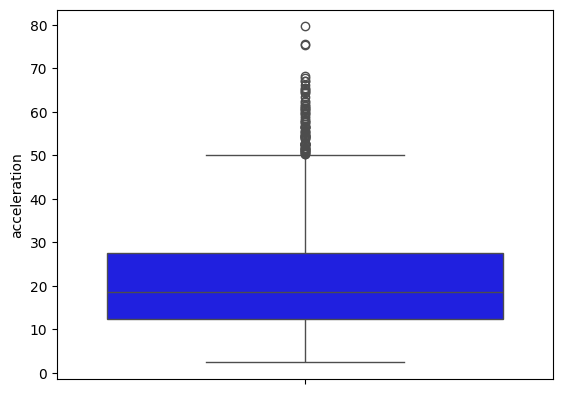

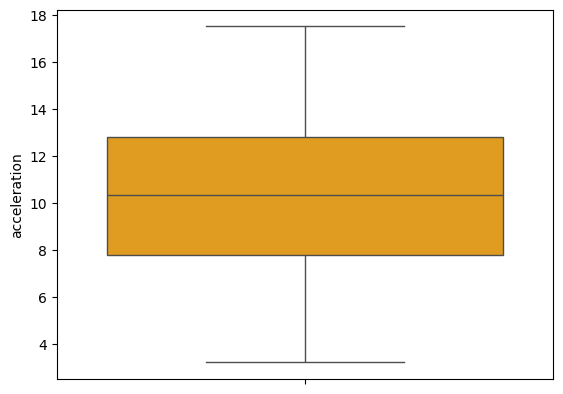

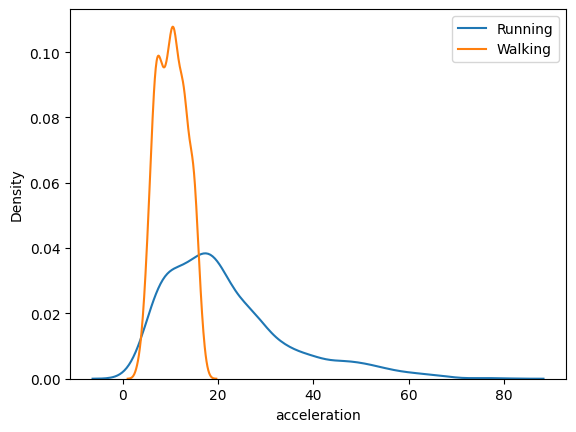

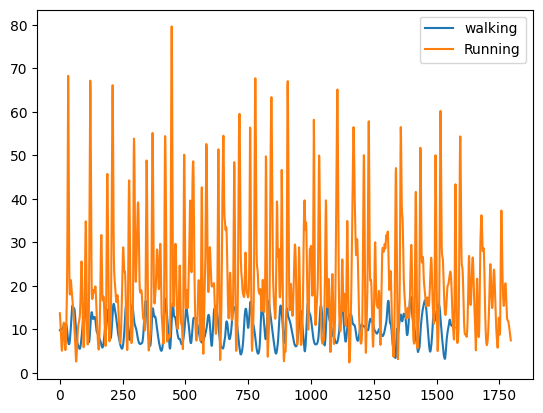

In [19]:
# Visualization on Acceleration Feature
sns.boxplot(ds_seg_run['acceleration'],color='blue')
plt.show()
sns.boxplot(ds_seg_walk['acceleration'],color='orange')
plt.show()

sns.kdeplot(ds_seg_run['acceleration'],label = 'Running')
sns.kdeplot(ds_seg_walk['acceleration'],label = "Walking")
plt.legend()
plt.show()
ds_seg_walk['acceleration'].plot(label='walking')
ds_seg_run['acceleration'].reset_index(drop=True).plot(label='Running')
plt.legend()
plt.show()


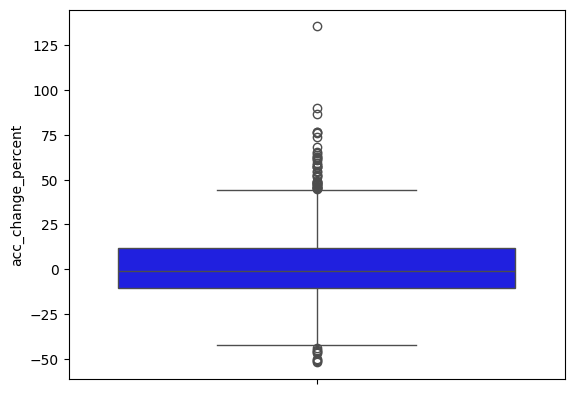

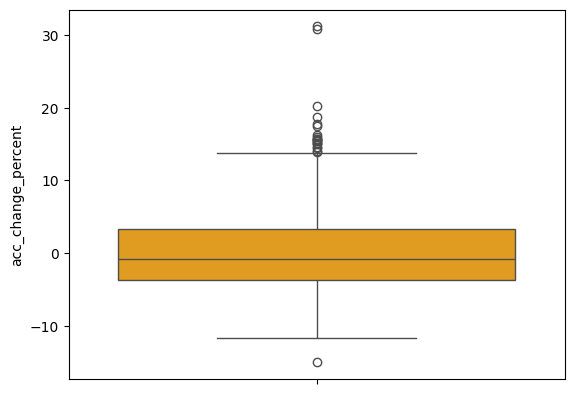

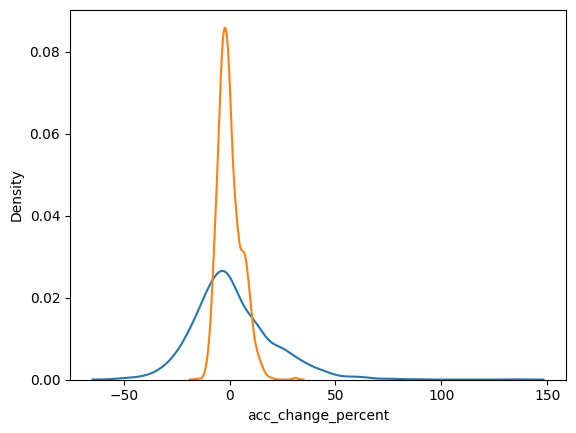

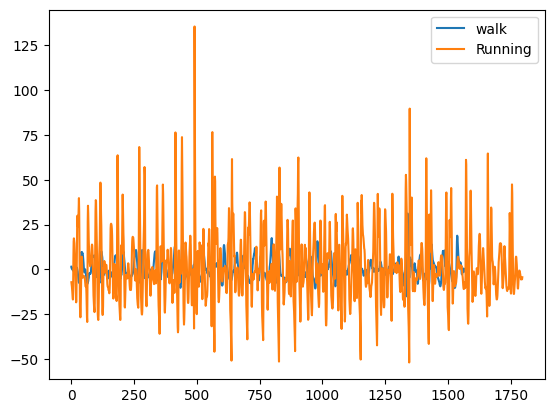

Acceleration Change(%) Running: 1.6507725398512136
Acceleration Change(%) Walking: 0.1490961691997132


In [20]:
# Visualization of Acceleration_%_change Feature
sns.boxplot(ds_seg_run['acc_change_percent'],color='blue')
plt.show()
sns.boxplot(ds_seg_walk['acc_change_percent'],color='orange')
plt.show()

sns.kdeplot(ds_seg_run['acc_change_percent'])
sns.kdeplot(ds_seg_walk['acc_change_percent'])
plt.show()
ds_seg_walk['acc_change_percent'].plot(label='walk')
ds_seg_run['acc_change_percent'].reset_index(drop=True).plot(label='Running')
plt.legend()
plt.show()

print("Acceleration Change(%) Running: {}".format(ds_seg_run['acc_change_percent'].dropna().mean()))
print("Acceleration Change(%) Walking: {}".format(ds_seg_walk['acc_change_percent'].dropna().mean()))

In [21]:
print(ds_seg_walk['acceleration'].diff().abs().mean())
print(ds_seg_run['acceleration'].diff().abs().mean())

print(ds_seg_walk['acceleration'].mean())
print(ds_seg_run['acceleration'].mean())

0.41741632473244034
2.8387229084181587
10.34543800304264
21.609069602797298


Let's apply this on the entire dataset.

### Adding features to dataset

In [42]:
ds['animal_Type'] = ds['animal_ID'].apply(lambda x: x[0])

In [24]:
ds['acceleration'] = np.sqrt((ds['ax']**2)+(ds['ay']**2)+(ds['az']**2))
ds['hg_acceleration'] =  np.sqrt((ds['axhg']**2)+(ds['ayhg']**2)+(ds['azhg']**2))

### Signal-Segment synthesis

In [45]:
ax_avg = []
ay_avg = []
az_avg = []
axhg_avg = []
ayhg_avg = []
azhg_avg = []
cx_avg = []
cy_avg = []
cz_avg = []
temp_avg = []
press_avg = []
acceleration_avg = []
hg_acceleration_avg = []
animal_type = []
label = []
segment_id = []
for segment in ds['segment_ID'].unique():
    segment_id.append(segment)
    ax_avg.append(ds[ds['segment_ID']==segment]['ax'].mean())
    ay_avg.append(ds[ds['segment_ID']==segment]['ay'].mean())
    az_avg.append(ds[ds['segment_ID']==segment]['az'].mean())
    acceleration_avg.append(ds[ds['segment_ID']==segment]['acceleration'].mean())

    axhg_avg.append(ds[ds['segment_ID']==segment]['axhg'].mean())
    ayhg_avg.append(ds[ds['segment_ID']==segment]['ayhg'].mean())
    azhg_avg.append(ds[ds['segment_ID']==segment]['azhg'].mean())
    hg_acceleration_avg.append(ds[ds['segment_ID']==segment]['hg_acceleration'].mean())

    cx_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cx'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())
    cy_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cy'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())
    cz_avg.append(pd.Series(signal.resample(ds[ds['segment_ID']==segment]['cz'].dropna(),ds[ds['segment_ID']==segment].shape[0])).mean())

    temp_avg.append(ds[ds['segment_ID']==segment]['temp'].mean())
    press_avg.append(ds[ds['segment_ID']==segment]['pressure'].mean())
    animal_type.append(ds[ds['segment_ID']==segment]['animal_Type'].unique()[0])
    label.append(ds[ds['segment_ID']==segment]['label'].unique()[0])



synthesized_df = pd.DataFrame({'segment_id':segment_id,
                               'animal_type':animal_type,
                                'ax_avg':ax_avg,
                                'ay_avg':ay_avg,
                                'az_avg':az_avg,
                                'acc_avg':acceleration_avg,
                                'hgacc_avg':hg_acceleration_avg,
                                'axhg_avg':axhg_avg,
                                'ayhg_avg':ayhg_avg,
                                'azhg_avg':azhg_avg,
                                'cx_avg':cx_avg,
                                'cy_avg':cy_avg,
                                'cz_avg':cz_avg,
                                'temp_avg':temp_avg,
                                'press_avg':press_avg,
                                'label':label})

In [46]:
synthesized_df.to_csv('./Data/Animal_Proc.csv')

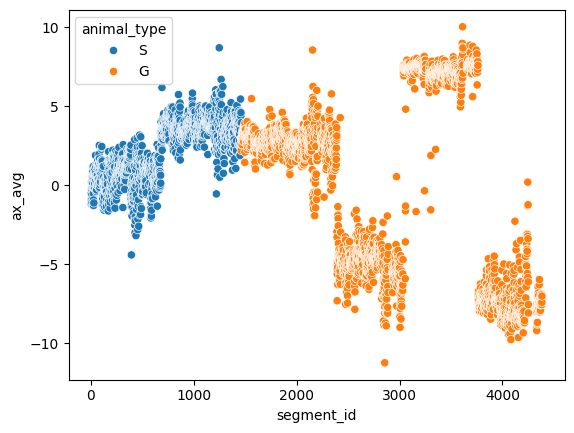

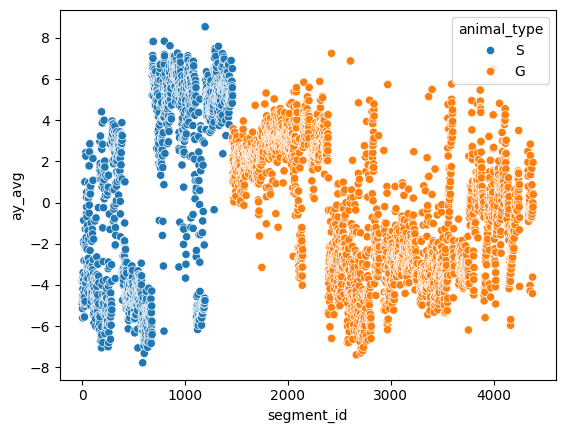

<Axes: xlabel='segment_id', ylabel='az_avg'>

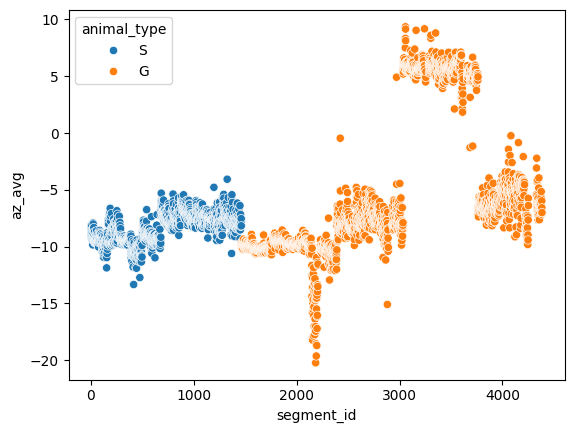

In [47]:
sns.scatterplot(y=synthesized_df['ax_avg'],x=synthesized_df['segment_id'],hue=synthesized_df['animal_type'])
plt.show()
sns.scatterplot(y=synthesized_df['ay_avg'],x=synthesized_df['segment_id'],hue=synthesized_df['animal_type'])
plt.show()
sns.scatterplot(y=synthesized_df['az_avg'],x=synthesized_df['segment_id'],hue=synthesized_df['animal_type'])

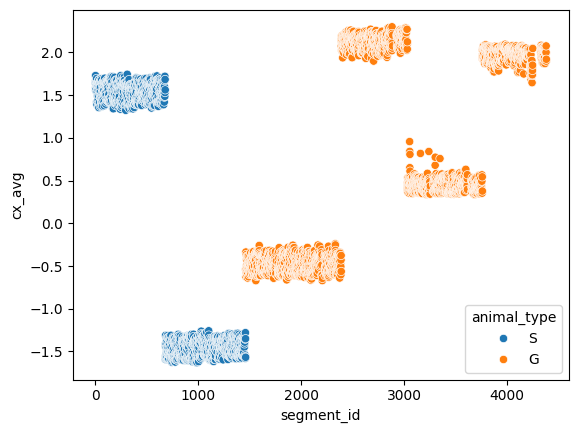

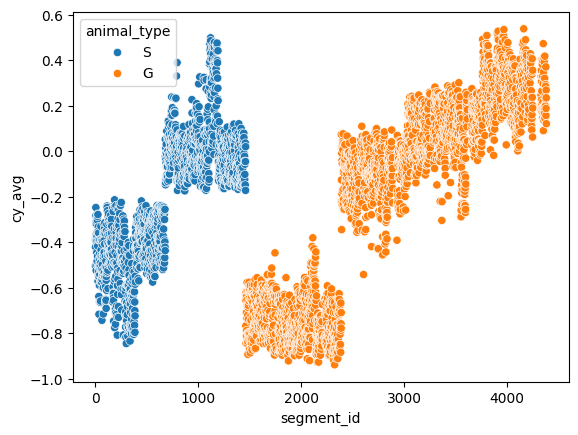

<Axes: xlabel='segment_id', ylabel='cz_avg'>

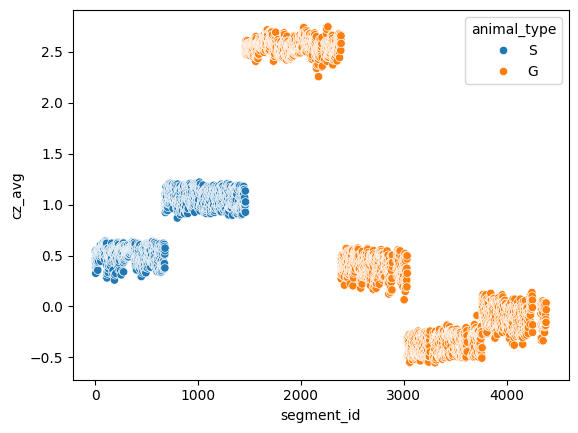

In [49]:
sns.scatterplot(y=synthesized_df['cx_avg'],x=synthesized_df['segment_id'],hue=synthesized_df['animal_type'])
plt.show()
sns.scatterplot(y=synthesized_df['cy_avg'],x=synthesized_df['segment_id'],hue=synthesized_df['animal_type'])
plt.show()
sns.scatterplot(y=synthesized_df['cz_avg'],x=synthesized_df['segment_id'],hue=synthesized_df['animal_type'])

<Axes: xlabel='hgacc_avg', ylabel='acc_avg'>

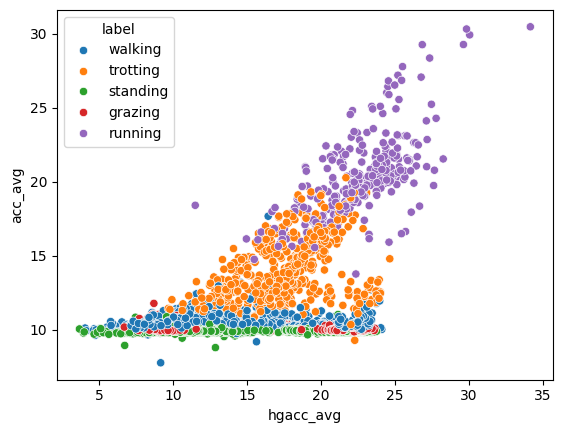

In [54]:
sns.scatterplot(x= synthesized_df['hgacc_avg'],y= synthesized_df['acc_avg'],hue=synthesized_df['label'])

In [33]:
synthesized_df = pd.read_csv('./Data/Animal_Proc.csv')
synthesized_df.drop(columns=synthesized_df.columns[0],inplace=True)

In [72]:
synthesized_df.head()

,segment_id,animal_type,ax_avg,ay_avg,az_avg,acc_avg,hgacc_avg,axhg_avg,ayhg_avg,azhg_avg,cx_avg,cy_avg,cz_avg,temp_avg,press_avg,label
0,1,S,-1.162629,-4.932205,-8.433746,10.345438,17.445160,3.775754,-2.101976,16.385164,1.653309,-0.504384,0.542080,27.363206,1008.223503,walking
1,2,S,-1.169836,-3.846880,-9.067179,10.376224,16.654438,3.797790,-0.930274,15.758703,1.729302,-0.421409,0.469509,27.360457,1008.229349,walking
2,3,S,-0.503200,-5.153028,-8.577048,10.715252,17.766766,4.550778,-2.304917,16.293251,1.636643,-0.385112,0.445751,27.344514,1008.223246,walking
3,4,S,-0.884993,-4.559569,-8.800155,10.401861,17.021269,4.201735,-1.744483,15.952331,1.640114,-0.393101,0.459137,26.560147,1008.211707,walking
4,5,S,-0.951361,-5.605595,-8.096315,10.879372,18.083656,4.165559,-2.822615,16.523371,1.586858,-0.247445,0.325374,26.475526,1008.260638,walking


In [73]:
synthesized_df['animal_type'] = synthesized_df['animal_type'].map({'S':0,'G':1})
X = synthesized_df.drop(columns=['segment_id','press_avg','temp_avg','label'])
y = synthesized_df['label']

label_encoder = LabelEncoder().fit(y) # label Encoding Target Variable.
y = label_encoder.transform(y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size= 0.25, 
                     stratify= y,
                     random_state= 123)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (3085, 12)
X_test shape: (1029, 12)


## Modelling

In [96]:
def run_classifier(clf, param_grid, title):
    # -----------------------------------------------------
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'accuracy')
    # -----------------------------------------------------
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    # -----------------------------------------------------
    print('Model: {}'.format(title))
    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred, average= 'weighted')*100))
    # -----------------------------------------------------
    # Plot confusion matrix
    cm = confusion_matrix(label_encoder.inverse_transform(y_test),label_encoder.inverse_transform(y_pred))
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Actual class")

    plt.show()
    # -----------------------------------------------------
    print("Classification Report: ")
    print(classification_report(label_encoder.inverse_transform(y_test),label_encoder.inverse_transform(y_pred)))

    # Evidently Report Generation
    # evidently Dataset 
    ref = pd.DataFrame({'target':y_train,'prediction':gs.best_estimator_.predict(X_train)})
    curr = pd.DataFrame({'target':y_test,'prediction':y_pred})
    column_mapping = ColumnMapping()
    column_mapping.target = 'target'
    column_mapping.prediction = 'prediction'
    drift_report = Report(metrics=[ClassificationPreset()])
    drift_report.run(reference_data=ref, current_data=curr, column_mapping=column_mapping)
    drift_report.save_html("{}_Report.html".format(title))

The best parameters are {'solver': 'newton-cg', 'penalty': 'l2'}
Model: Logistic Regression
Accuracy score: 83.97%
Precision score: 84.02%
Recall score: 83.97%


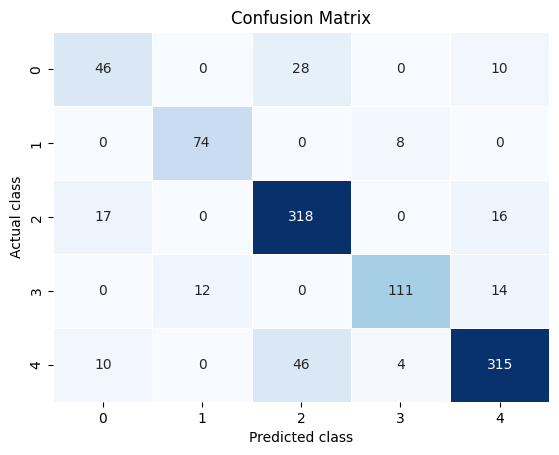

Classification Report: 
              precision    recall  f1-score   support

     grazing       0.63      0.55      0.59        84
     running       0.86      0.90      0.88        82
    standing       0.81      0.91      0.86       351
    trotting       0.90      0.81      0.85       137
     walking       0.89      0.84      0.86       375

    accuracy                           0.84      1029
   macro avg       0.82      0.80      0.81      1029
weighted avg       0.84      0.84      0.84      1029



In [92]:


lr = LogisticRegression()
decision_tree_model = DecisionTreeClassifier(random_state=0)
random_forest_model = RandomForestClassifier(random_state=2)
logistic_regression_model = LogisticRegression(random_state=42)
k_nearest_neighbour_model = KNeighborsClassifier(n_neighbors=3)
ADA_boost_model = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0)
GradientBoost_model = XGBClassifier(tree_method='gpu_hist')
support_vector_model = svm.SVC(kernel='linear',probability=True)

param_grid = {'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

run_classifier(lr, param_grid, 'Logistic Regression')

The best parameters are {'max_depth': None, 'criterion': 'entropy'}
Model: Decision Tree model
Accuracy score: 85.62%
Precision score: 85.94%
Recall score: 85.62%


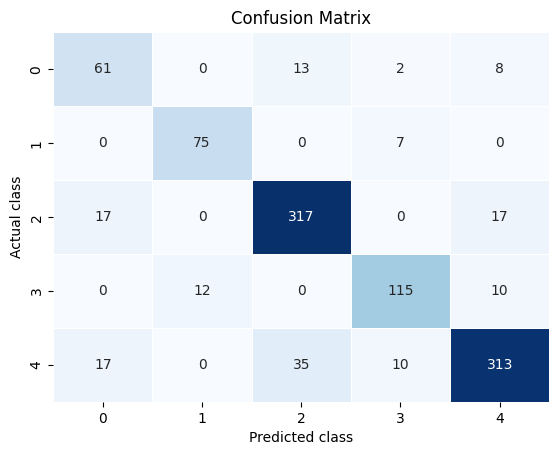

Classification Report: 
              precision    recall  f1-score   support

     grazing       0.64      0.73      0.68        84
     running       0.86      0.91      0.89        82
    standing       0.87      0.90      0.89       351
    trotting       0.86      0.84      0.85       137
     walking       0.90      0.83      0.87       375

    accuracy                           0.86      1029
   macro avg       0.83      0.84      0.83      1029
weighted avg       0.86      0.86      0.86      1029



In [99]:
param_dist = {"max_depth": [3, None],
              "criterion": ["gini", "entropy"]}
run_classifier(decision_tree_model, param_dist, 'Decision Tree model')